In [1]:
from fastai import *
from fastai.tabular import *
from fastai.text import *

In [2]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import Counter
import random

In [3]:
path = os.getcwd()

In [4]:
#sentiment columns.csv is a file where only the subjective notes in patients who 
#have them have been kept
data = pd.read_csv('sentiment_columns.csv')

In [5]:
len(data)

110640

In [6]:
data.head()

,Unnamed: 0,SubjectiveNotes,outcome
0,148,^c^^^^ctasSUN=pt states that she feels shaky. ...,discharge
1,156,^c^^^^ctasSUN=,discharge
2,197,^c^^^^ctasSUN=Pt states no pain.,discharge
3,217,^c^^^^ctasSUN=denied chest pain,discharge
4,218,^c^^^^ctasSUN=Denies pain. Eating ED lunch at ...,discharge


In [31]:
for note in list(data['SubjectiveNotes'])[:10]:
    print (note)

^c^^^^ctasSUN=pt states that she feels shaky.  pt denies any pain.
^c^^^^ctasSUN=
^c^^^^ctasSUN=Pt states no pain.
^c^^^^ctasSUN=denied chest pain
^c^^^^ctasSUN=Denies pain. Eating ED lunch at triage
^c^^^^ctasSUN=pt. c/o pain  on the left wrist and left ankle , no obvious deformity , with minor laceration  in between left thumb, and  2nd digit left finger .
^c^^^^ctasSUN=The patient states his pain is manageable. Still shivering-patient was laying on a cold concrete floor. Denies any other injuries other then the left leg.
^c^^^^ctasSUN=As per the police the patient-was having an agressive altercation with his mother.  The patient was to have mentioned to a call taker that he was suicidal.  The patient has a his of autism and some behaviour issues.
^c^^^^ctasSUN=pt states feels weak, c/o pain to feet x 3-4 days, nauseated
^c^^^^ctasSUN=c/o pain of frontal headache, continues to c/o generalized body pain.


In [7]:
#this field is to strip the leading characters from the subjective notes field
data['subj'] = data['SubjectiveNotes'].str[14:]

In [8]:
data.head()

,Unnamed: 0,SubjectiveNotes,outcome,subj
0,148,^c^^^^ctasSUN=pt states that she feels shaky. ...,discharge,pt states that she feels shaky. pt denies any...
1,156,^c^^^^ctasSUN=,discharge,
2,197,^c^^^^ctasSUN=Pt states no pain.,discharge,Pt states no pain.
3,217,^c^^^^ctasSUN=denied chest pain,discharge,denied chest pain
4,218,^c^^^^ctasSUN=Denies pain. Eating ED lunch at ...,discharge,Denies pain. Eating ED lunch at triage


In [9]:
#and this drops some fields that were empty after stripping the leading characters
data = data[data['subj'] != '']

In [10]:
len(data)

110227

In [11]:
#save the new clean dataframe to a csv file
data[['outcome', 'subj']].to_csv('clean_sentiment_columns.csv')


# Skip to here now when retrying


In [4]:
data = pd.read_csv('clean_sentiment_columns.csv')

In [5]:
data.head()

,Unnamed: 0,outcome,subj
0,0,discharge,pt states that she feels shaky. pt denies any...
1,2,discharge,Pt states no pain.
2,3,discharge,denied chest pain
3,4,discharge,Denies pain. Eating ED lunch at triage
4,5,discharge,pt. c/o pain on the left wrist and left ankle...


In [6]:
count = Counter(data['outcome']); count

Counter({'discharge': 99885, 'sadmit': 1565, 'madmit': 8136, 'ICU': 641})

### the next several cells were use to determine the best training strategy for the language model

In [5]:
#random sampling of dataset to make a smaller set to work with
ltd_data = data.sample(n=20000,random_state=42)

In [6]:
len(ltd_data)

20000

In [7]:
count2 = Counter(ltd_data['outcome']); count2

Counter({'discharge': 18146, 'madmit': 1471, 'sadmit': 263, 'ICU': 120})

#### these next 4 cells are creating "databunches" that I can use to train the language model and classifier later

In [8]:
#language model databunch based on full dataset
data_lm2 = (TextList.from_df(data, cols='subj')
                   .split_by_rand_pct(0.2)
                   .label_for_lm()
                   .databunch())

In [9]:
#language model databunch based on data subset
data_lm = (TextList.from_df(ltd_data, cols='subj')
                   .split_by_rand_pct(0.2)
                   .label_for_lm()
                   .databunch())

In [10]:
#classification databunch for small dataset and languange model
data_clas = (TextList.from_df(ltd_data, cols='subj',vocab=data_lm.vocab)
                   .split_by_rand_pct(0.2)
                   .label_from_df(cols = 'outcome')
                   .databunch())

In [11]:
#classification databunch for small dataset, but full languange model dataset
data_clas2 = (TextList.from_df(ltd_data, cols='subj',vocab=data_lm2.vocab)
                   .split_by_rand_pct(0.2)
                   .label_from_df(cols = 'outcome')
                   .databunch())

saving the large databunches...

In [30]:
data_lm2.save(path + '/large_lm')

In [31]:
data_clas2.save(path + '/large_clas_db')

##### First few attempts at training the languange model

Later I make a little function for doing it


In [17]:
lmlearn = language_model_learner(data_lm2, arch = AWD_LSTM, drop_mult=0.3)

In [18]:
lmlearn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.190878,3.045542,0.389300,07:24
1,3.035401,2.900266,0.403979,07:29
2,2.929997,2.856863,0.410146,07:27


In [19]:
lmlearn.unfreeze()

In [20]:
lmlearn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))
lmlearn.save_encoder(path + '/edsent_enc1')
lmlearn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))
lmlearn.save_encoder(path + '/edsent_enc2')

epoch,train_loss,valid_loss,accuracy,time
0,2.709756,2.669126,0.437132,09:13
1,2.595951,2.558663,0.454293,09:08
2,2.439759,2.444377,0.470944,09:07
3,2.254719,2.367875,0.483034,09:06
4,2.072818,2.367422,0.484380,09:08


epoch,train_loss,valid_loss,accuracy,time
0,2.250499,2.435033,0.473229,09:07
1,2.401551,2.462911,0.468879,09:07
2,2.294977,2.406534,0.477761,09:07
3,2.107645,2.366459,0.484726,09:08
4,1.923508,2.382156,0.485008,09:09


OK.  This works quite well.  but the second set of training wasn't useful.  need to play with different language model training schemes but will use the smaller dataset

In [22]:
lmlearn = language_model_learner(data_lm, arch = AWD_LSTM, drop_mult=0.3)

In [23]:
lmlearn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))
lmlearn.unfreeze()
lmlearn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))
lmlearn.save_encoder(path + '/small_edsent_enc1')
lmlearn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))
lmlearn.save_encoder(path + '/small_edsent_enc2')

epoch,train_loss,valid_loss,accuracy,time
0,4.527524,3.555708,0.338179,00:32
1,3.606226,3.243258,0.363263,00:32
2,3.294366,3.195796,0.367485,00:33


epoch,train_loss,valid_loss,accuracy,time
0,3.074825,3.008442,0.386049,00:42
1,2.904727,2.852356,0.408064,00:42
2,2.617094,2.772868,0.420285,00:42
3,2.239494,2.768783,0.425223,00:42
4,1.835355,2.842323,0.421131,00:42


epoch,train_loss,valid_loss,accuracy,time
0,1.825878,2.901501,0.411282,00:42
1,2.128600,2.890018,0.410733,00:42
2,1.951956,2.942111,0.412444,00:42
3,1.538968,3.051043,0.411337,00:42
4,1.159738,3.139566,0.408687,00:42


In [24]:
lmlearn = language_model_learner(data_lm, arch = AWD_LSTM, drop_mult=0.3)
lmlearn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))
lmlearn.unfreeze()
lmlearn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.531025,3.561277,0.337333,00:33
1,3.604819,3.242844,0.362984,00:33
2,3.309505,3.197489,0.367401,00:33


epoch,train_loss,valid_loss,accuracy,time
0,3.049761,2.997824,0.390244,00:42
1,2.934725,2.911860,0.395350,00:42
2,2.785132,2.837442,0.409459,00:42
3,2.586400,2.814339,0.411756,00:42
4,2.344484,2.819933,0.417560,00:42
5,2.038406,2.875622,0.417866,00:42
6,1.707402,2.968088,0.412946,00:42
7,1.346949,3.097973,0.409477,00:42
8,1.096840,3.174539,0.407952,00:42
9,0.969622,3.205173,0.407087,00:42


In [25]:
lmlearn = language_model_learner(data_lm, arch = AWD_LSTM, drop_mult=0.3)
lmlearn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
lmlearn.unfreeze()
lmlearn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.170476,3.581429,0.337565,00:33


epoch,train_loss,valid_loss,accuracy,time
0,3.309155,3.139112,0.378553,00:42
1,3.002153,2.873574,0.407943,00:42
2,2.675266,2.772430,0.420294,00:42
3,2.289103,2.756126,0.427716,00:42
4,1.894931,2.824773,0.424470,00:42


In [26]:
lmlearn = language_model_learner(data_lm, arch = AWD_LSTM, drop_mult=0.3)
lmlearn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
lmlearn.unfreeze()
lmlearn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.175306,3.589924,0.337612,00:32


epoch,train_loss,valid_loss,accuracy,time
0,3.350632,3.128212,0.383603,00:42
1,3.092456,2.958846,0.394950,00:42
2,2.857618,2.845159,0.408891,00:42
3,2.627907,2.808815,0.414881,00:42
4,2.376124,2.821278,0.415885,00:42
5,2.065609,2.862792,0.417559,00:42
6,1.709566,2.961821,0.413839,00:42
7,1.365878,3.075692,0.410240,00:42
8,1.104946,3.161106,0.409375,00:42
9,0.986290,3.187677,0.408891,00:42


now gonna do this on the full dataset

In [33]:
lmlearn = language_model_learner(data_lm2, arch = AWD_LSTM, drop_mult=0.3)
lmlearn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))
lmlearn.unfreeze()
lmlearn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.200046,3.042006,0.390644,07:05
1,3.025647,2.892786,0.406584,07:06
2,2.908253,2.854008,0.411350,07:06


epoch,train_loss,valid_loss,accuracy,time
0,2.693254,2.652823,0.439703,08:43
1,2.590799,2.551898,0.456382,08:42
2,2.436969,2.442677,0.471906,08:41
3,2.249374,2.366883,0.483799,08:40
4,2.079566,2.365440,0.485378,08:40


In [1]:
#the above training scheme is good so I'm going to save this as my language model
#which is basically saving the embedding matrix from the language modelling nerual network
lmlearn.save_encoder(path + '/edsent_v2_enc2')

NameError: name 'lmlearn' is not defined

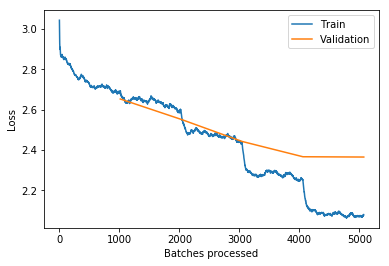

In [35]:
lmlearn.recorder.plot_losses()

In [21]:
def tune_language_model(save_name, data = data_lm, epochs = 1, lr2 = 1e-3, arch = AWD_LSTM):
    model = language_model_learner(data, arch = arch, drop_mult=0.3)
    model.fit_one_cycle(epochs, 1e-2, moms=(0.8,0.7))
    model.fit_one_cycle(epochs, lr2, moms=(0.8,0.7))
    model.save_encoder(path + '/' + save_name + '_enc1')
    model.fit_one_cycle(3*epochs, lr2, moms=(0.8,0.7))
    model.save_encoder(path + '/' + save_name + '_enc2')
    model.recorder.plot_losses()
    return model

All that work was done to get the best language model I could get which seems to have
accuracy of about 48%

Now on to training the classifier

In [27]:
f1 = FBeta(beta=1, average = 'weighted')
def train_triage_classifier(encoder_name, datac = data_clas2, datal = data_lm2, 
                            mets = [accuracy,f1], num_cycles = 1, lr = 1e-2, drop_mult = 0.5):
    model = text_classifier_learner(datac, metrics = mets, arch = AWD_LSTM, drop_mult=drop_mult)
    model.load_encoder(path + '/' + encoder_name)
    model.fit_one_cycle(num_cycles, lr, moms=(0.8,0.7))
    model.freeze_to(-2)
    model.fit_one_cycle(num_cycles, slice(lr/(2.6**4),lr), moms=(0.8,0.7))
    model.freeze_to(-3)
    model.fit_one_cycle(num_cycles, slice((lr/2)/(2.6**4),(lr/2)), moms=(0.8,0.7))
    model.unfreeze()
    model.fit_one_cycle(num_cycles*5, slice((lr/100)/(2.6**4),(lr/100)), moms=(0.8,0.7))
    model.recorder.plot_losses()
    return model

#### first pass at training classifier (I am using the small dataset here)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.559122,0.478132,0.899000,0.858694,00:41


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.331076,0.342390,0.902500,0.859293,00:50


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.329459,0.335130,0.902500,0.860183,01:18


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.314491,0.334055,0.902500,0.860183,01:42
1,0.302573,0.333724,0.902500,0.860183,01:43
2,0.310178,0.333509,0.902250,0.859606,01:44
3,0.319359,0.334255,0.902250,0.859606,01:43
4,0.310490,0.333669,0.902250,0.859606,01:41


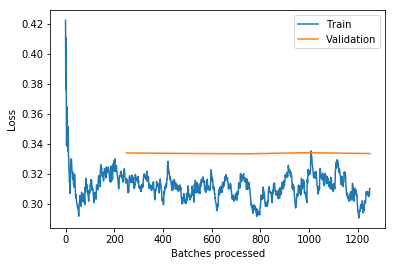

In [38]:
sent_learn = train_triage_classifier('edsent_v2_enc2', datac = data_clas2, num_cycles = 1, lr = 1e-3)

In [39]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

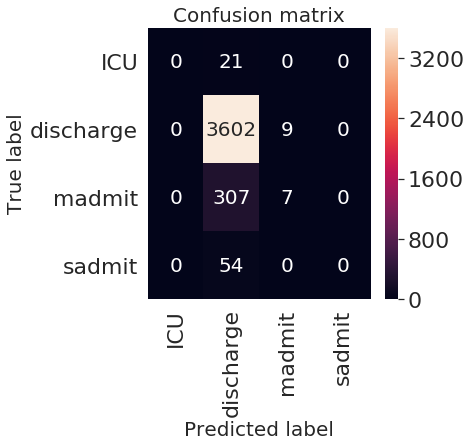

In [40]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

LABELS = data_clas2.classes

confusion_matrix = metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [41]:
sent_learn.save(path + '/models/edtriage1')

so the results above show high accuracy and f-score, but very few admission predictions

now gonna train longer and see what happens

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.355121,0.333003,0.901250,0.857269,00:41
1,0.320775,0.328875,0.902500,0.857561,00:41
2,0.300077,0.326030,0.901750,0.857174,00:41


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.318173,0.337101,0.902500,0.857561,00:49
1,0.300910,0.330482,0.902500,0.860635,00:49
2,0.268723,0.339622,0.899000,0.865421,00:49


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.263906,0.355196,0.900000,0.863574,01:19
1,0.249495,0.353632,0.895750,0.865016,01:18
2,0.209824,0.375847,0.896500,0.866136,01:19


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.199225,0.380323,0.896250,0.864987,01:42
1,0.181380,0.373242,0.893750,0.866556,01:42
2,0.189472,0.375942,0.894000,0.866893,01:42
3,0.191652,0.378475,0.893000,0.866787,01:41
4,0.187866,0.388004,0.893000,0.864361,01:43
5,0.202788,0.388694,0.893000,0.865927,01:43
6,0.192430,0.392026,0.894250,0.865556,01:42
7,0.187565,0.388038,0.893500,0.866516,01:44
8,0.186231,0.393241,0.892500,0.865563,01:43
9,0.195616,0.395961,0.892250,0.866328,01:42


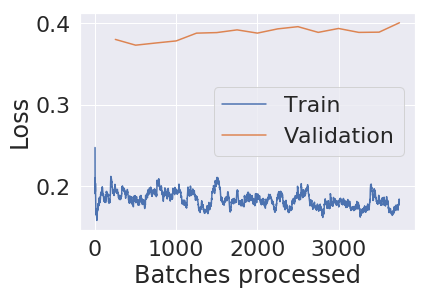

In [42]:
sent_learn = train_triage_classifier('edsent_v2_enc2', datac = data_clas2, num_cycles = 3, lr = 1e-2)

In [43]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

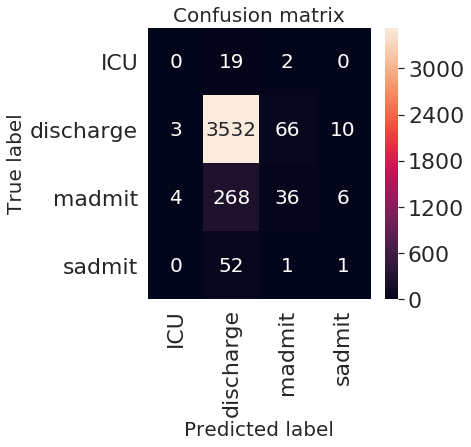

In [44]:
confusion_matrix = metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

this was a little worse because it overfit the data

In [26]:
data_lm2 = load_data(path, 'large_lm')
data_clas2 = load_data(path, 'large_clas_db')

In [12]:
model = text_classifier_learner(data_clas2, arch = AWD_LSTM, drop_mult=0.5)

In [14]:
model.load(path + '/models/edtriage1');

In [15]:
model.summary()

Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [51, 400]            0          False     
______________________________________________________________________
RNNDropout           [51, 1150]           0          False     
______________________________________________________________________
RNNDropout           [51, 1150]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
______________________________________________________________

In [17]:
preds, targets = model.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

In [19]:
f1_scores = metrics.f1_score(targets, predictions, average = None)

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
f1_scores

array([0.      , 0.948519, 0.042424, 0.      ])

In [22]:
f1_scores2 = metrics.f1_score(targets, predictions, average = 'weighted')

In [23]:
f1_scores2

0.8596056157360306

In [28]:
f1_scores3 = metrics.f1_score(targets, predictions, average = 'macro'); f1_scores3

0.2477357511919724

In [29]:
acc = metrics.accuracy_score(targets, predictions); acc

0.90225

so clearly we overfit long before we get good.  let's try this again, but we will do shorter training and more dropout

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.571676,0.503379,0.897750,0.857699,00:41


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.371055,0.344525,0.902500,0.857446,00:50


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.344041,0.336515,0.902750,0.858046,01:20


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.321526,0.335079,0.902750,0.858512,01:45
1,0.310394,0.335478,0.902750,0.858512,01:45
2,0.316377,0.336074,0.903000,0.859105,01:45
3,0.337970,0.334975,0.903000,0.858643,01:45
4,0.328497,0.335041,0.903000,0.858175,01:45


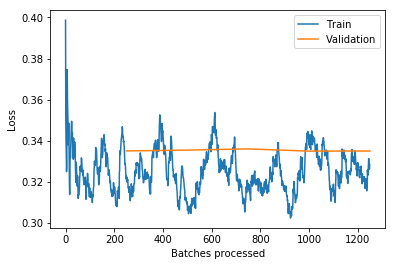

In [34]:
sent_learn = train_triage_classifier('edsent_v2_enc2', datac = data_clas2, num_cycles = 1, lr = 1e-3, drop_mult = 0.7)

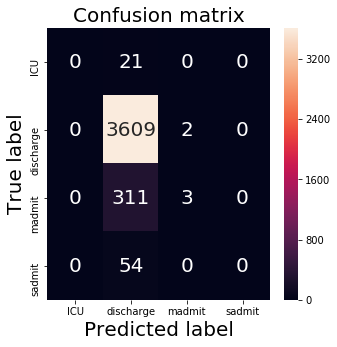

In [36]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

confusion_matrix = metrics.confusion_matrix(targets, predictions)
LABELS = data_clas2.classes

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

for interest sake I'm going to see what the model looks like before we do any training

In [37]:
model = text_classifier_learner(data_clas2, arch = AWD_LSTM, drop_mult=0.5)

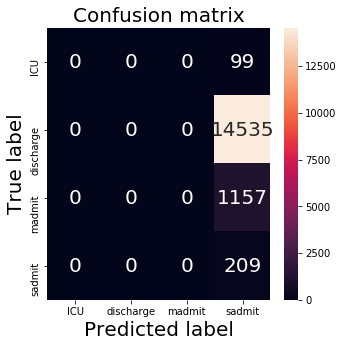

In [39]:
preds, targets = model.get_preds(DatasetType.Train) 
predictions = np.argmax(preds, axis = 1) 

confusion_matrix = metrics.confusion_matrix(targets, predictions)
LABELS = data_clas2.classes

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

Gonna try a new approach where I just train on admitted patients to see if I can distinguish them:

In [7]:
len(data)

110227

In [8]:
dc_data = data[data['outcome'] == 'discharge']

In [9]:
len(dc_data)

99885

In [10]:
admit_data = data[data['outcome'] != 'discharge']

In [12]:
len(admit_data)

10342

In [13]:
len(data) == len(dc_data) + len(admit_data)

True

In [14]:
dc_count = Counter(dc_data.outcome); dc_count

Counter({'discharge': 99885})

In [15]:
ad_count = Counter(admit_data.outcome); ad_count

Counter({'sadmit': 1565, 'madmit': 8136, 'ICU': 641})

In [17]:
dc_data.to_csv('discharges')

In [18]:
admit_data.to_csv('admissions')

In [19]:
data_lm2 = load_data(path, 'large_lm')

In [20]:
admit_clas = (TextList.from_df(admit_data, cols='subj',vocab=data_lm2.vocab)
                   .split_by_rand_pct(0.2)
                   .label_from_df(cols = 'outcome')
                   .databunch())

In [22]:
admit_clas.classes

['ICU', 'madmit', 'sadmit']

In [23]:
admit_clas.vocab.itos == data_lm2.vocab.itos

True

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.895672,0.804704,0.750484,0.749251,00:25


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.650800,0.605090,0.791586,0.766759,00:30


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.560469,0.541517,0.799807,0.761267,00:49


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.545893,0.542009,0.795938,0.757783,01:03
1,0.532714,0.540689,0.797389,0.759073,01:01
2,0.530488,0.540463,0.797872,0.763657,01:03
3,0.543008,0.539007,0.794004,0.755700,01:00
4,0.535125,0.540949,0.799323,0.762522,01:05


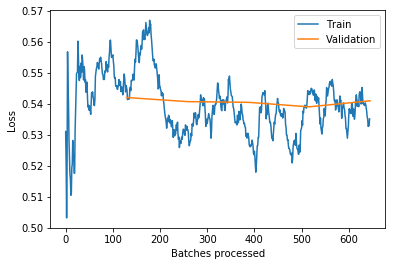

In [28]:
sent_learn = train_triage_classifier('edsent_v2_enc2', datac = admit_clas, num_cycles = 1, lr = 1e-3, drop_mult = 0.7)

In [30]:
txt_ci = TextClassificationInterpretation.from_learner(sent_learn)

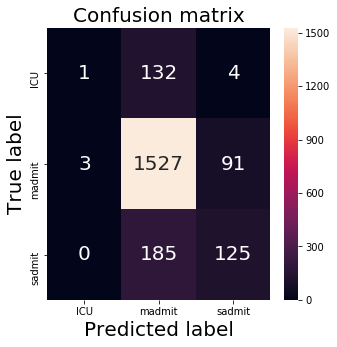

In [37]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

confusion_matrix = metrics.confusion_matrix(targets, predictions)
LABELS = admit_clas.classes

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

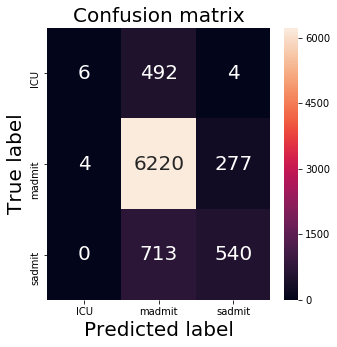

In [38]:
preds, targets = sent_learn.get_preds(DatasetType.Train) 
predictions = np.argmax(preds, axis = 1) 

confusion_matrix = metrics.confusion_matrix(targets, predictions)
LABELS = admit_clas.classes

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

still not very good.  gonne try to split again

gonna look at differentiating admitted patients between the ward and ICU

In [39]:
admit_data['ward/icu'] = admit_data['outcome'].map(
{'ICU': 'ICU',
 'madmit': 'ward',
 'sadmit' : 'ward',
 })

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [40]:
admit_data.head()

,Unnamed: 0,outcome,subj,ward/icu
5,6,sadmit,The patient states his pain is manageable. Sti...,ward
6,7,madmit,As per the police the patient-was having an ag...,ward
12,13,sadmit,States she was taking out the garbage when she...,ward
14,15,madmit,"C/o chest heaviness, with sweating. Pt. denies...",ward
20,21,madmit,pt denies any pain.,ward


In [41]:
count3 = Counter(admit_data['ward/icu']); count3

Counter({'ward': 9701, 'ICU': 641})

In [43]:
floor_clas = (TextList.from_df(admit_data, cols='subj',vocab=data_lm2.vocab)
                   .split_by_rand_pct(0.2)
                   .label_from_df(cols = 'ward/icu')
                   .databunch())

In [44]:
floor_clas.classes

['ICU', 'ward']

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.546206,0.493368,0.878143,0.892003,00:25


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.328051,0.284913,0.936170,0.916652,00:31


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.234372,0.234789,0.937137,0.917226,00:47


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.227766,0.227815,0.939072,0.918381,01:02
1,0.230966,0.227435,0.939072,0.918381,01:02
2,0.225872,0.226474,0.938588,0.918091,01:07
3,0.219498,0.225829,0.939072,0.918381,01:02
4,0.223254,0.228208,0.938104,0.917803,01:00


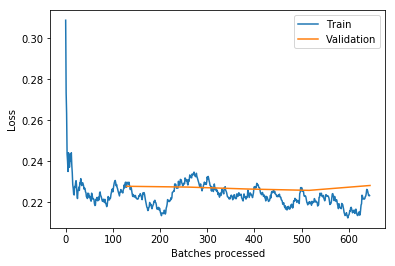

In [45]:
sent_learn = train_triage_classifier('edsent_v2_enc2', datac = floor_clas, num_cycles = 1, lr = 1e-3, drop_mult = 0.5)

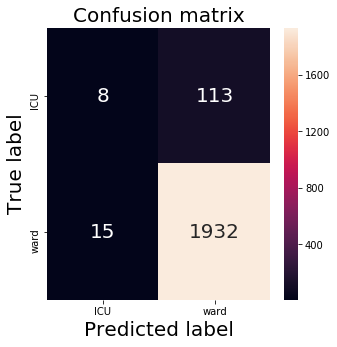

In [46]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

confusion_matrix = metrics.confusion_matrix(targets, predictions)
LABELS = floor_clas.classes

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [51]:
f_score = metrics.f1_score(targets, predictions, average = 'binary')

In [52]:
f_score

0.9679358717434869

In [53]:
f_score = metrics.f1_score(targets, predictions, average = None)

In [54]:
f_score

array([0.111111, 0.967936])

#### this is not bad by the numbers but doesn't detect the outlier (ICU admission) very well

now gonna try admit vs. d/c

In [55]:
data['admission'] = data['outcome'].map(
{'ICU': 'admit',
 'madmit': 'admit',
 'sadmit' : 'admit',
 'discharge' : 'discharge'
 })

In [ ]:
admit_data['ward/icu'] = admit_data['outcome'].map(
{'ICU': 'ICU',
 'madmit': 'ward',
 'sadmit' : 'ward',
 })

In [56]:
data_clas = (TextList.from_df(data, cols='subj',vocab=data_lm2.vocab)
                   .split_by_rand_pct(0.2)
                   .label_from_df(cols = 'admission')
                   .databunch())

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.260799,0.258465,0.909957,0.871546,04:03


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.269608,0.253495,0.910048,0.873052,04:55


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.258076,0.253368,0.910955,0.875721,07:39


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.246777,0.252684,0.910683,0.874907,10:46
1,0.275943,0.252002,0.910229,0.873308,09:58
2,0.271188,0.252132,0.910501,0.874360,10:39
3,0.250602,0.251676,0.910229,0.873532,09:59
4,0.268198,0.251902,0.911046,0.876418,10:48


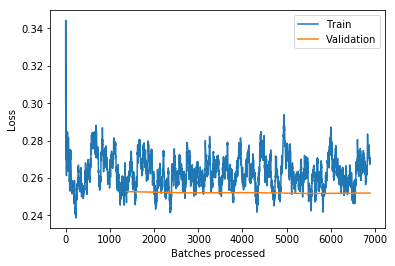

In [57]:
sent_learn = train_triage_classifier('edsent_v2_enc2', datac = data_clas, num_cycles = 1, lr = 1e-3, drop_mult = 0.5)

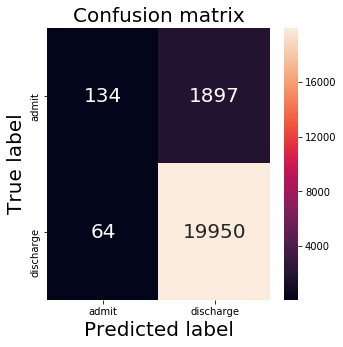

In [58]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

confusion_matrix = metrics.confusion_matrix(targets, predictions)
LABELS = data_clas.classes

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

same old problem.  good numbers but not very useful predictions